# imports

In [1]:
#imports
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
import pandas_ta as ta
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as Forest
from sklearn.metrics import accuracy_score
from scipy.signal import argrelextrema
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [2]:
def pivot_point( df) :
  pivot_points = []
  # support1 = []
  # support2 = []
  # support3 = []
  # resistance1 = []
  # resistance2 = []
  # resistance3 = []

  for _, row in df.iterrows():
      high = row['High']
      low = row['Low']
      close = row['Close']

      pivot_point = (high + low + close) / 3
      # s1 = (2 * pivot_point) - high
      # s2 = pivot_point - (high - low)
      # s3 = low - 2 * (high - pivot_point)
      # r1 = (2 * pivot_point) - low
      # r2 = pivot_point + (high - low)
      # r3 = high + 2 * (pivot_point - low)

      pivot_points.append(round(pivot_point, 2))
      # support1.append(s1)
      # support2.append(s2)
      # support3.append(s3)
      # resistance1.append(r1)
      # resistance2.append(r2)
      # resistance3.append(r3)

  # df['Pivot'] = pivot_points
  # df['Support 1'] = support1
  # df['Support 2'] = support2
  # df['Support 3'] = support3
  # df['Resistance 1'] = resistance1
  # df['Resistance 2'] = resistance2
  # df['Resistance 3'] = resistance3
  return pivot_points


# Assuming 'df' is your DataFrame with a 'price' column
def candle_color(df):
    color = []

    for idx in df.index:
        if df['Open'][idx] > df['Close'][idx]:
            color.append(-1)
        elif df['Open'][idx] < df['Close'][idx]:
            color.append(1)
        else:
            color.append(0)  # Add a neutral color if open and close prices are equal

    return color



def fair_value_gap(df):
    high, low = df['High'], df['Low']
    fvg = [None] * len(df)
    for row in range(1, len(df) - 1):
        # bulish
        if not high[row - 1] >= low[row + 1]:
            # Placeholder for the missing logic
            fvg[row] = (low[row + 1] - high[row - 1])  # Example: Storing the row index in the fvg list
        # Bearish
        if not low[row - 1] <= high[row + 1]:
            # Placeholder for the missing logic
            fvg[row] = ( high[row + 1] - low[row - 1])  # Example: Storing the row index in the fvg list
        
    return fvg


def zigzag(df, length, source):
  z_os = np.zeros(len(df))
  valtop = np.nan
  valbtm = np.nan
  df['z_btm'] = np.nan
  df['z_top'] = np.nan

  for i in range(length, len(df)):
    upper = df[source].iloc[i-length:i].max()
    lower = df[source].iloc[i-length:i].min()
    df.loc[i, 'z_btm'] = lower
    df.loc[i, 'z_top'] = upper
    z_os[i] = df[source].iloc[i]
    
  return z_os, df['z_btm'], df['z_top']




# variables

In [3]:
#Reading Data
df = pd.read_csv("C:\\Users\AmirHussain\Desktop\machine-Learning-tradert-bot-main\Datas\XAUUSDM15.csv" , 
                   encoding = 'utf-16', 
                   names =  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', '0'] )

df.drop(['0', 'Volume'], inplace= True, axis= 1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', drop=True, inplace = True)


In [4]:
# _, df['z_btm'], df['z_top'] = zigzag(df, length=5, source='Open')


In [5]:
# back_candel = 3
# df['hl2'] = (df['High'] - df['Low']) / 2
# df['Slope'] = df['hl2'].rolling(window=back_candel).apply(lambda x: np.polyfit(np.arange(back_candel), x, 1)[0])

In [6]:
df['color'] = candle_color(df)
df['fvg'] = fair_value_gap(df)

In [7]:
df['ho diff'] =  df['High'] - df['Open']
df['lo diff'] =  df['Low'] - df['Open']

In [8]:
df['Pivot'] = pivot_point(df)
df['next'] = df['Open'].shift(-1)



df['ma 1'] = ta.ma('sma', df['Open'], length = 5)
df['ma 2'] = ta.ma('sma', df['Open'], length = 10)

df['rsi'] = ta.rsi(df['Open'], 21)
df['mom'] = ta.mom(df['Open'], 21)
macd = ta.macd(df['Open'], fastperiod=13, slowperiod=36, signalperiod=9)
df['atr'] = ta.atr(df['High'], df['Low'], df['Close'], 13)
df['Open-pivot'] = df['Open'] - df['Pivot']
df = df.join(macd['MACD_12_26_9'])
df = df.rename(columns={ "MACD_12_26_9": "macd"})
df['crossover'] = ((df['ma 1'] >= df['ma 2']   ) & (df['ma 1'].shift(1) < df['ma 2'].shift(1)) ).astype(int)
df['crossunder'] =( (df['ma 1'] <= df['ma 2']  ) & (df['ma 1'].shift(1) > df['ma 2'].shift(1))) .astype(int)

df = df[36:]
df.reset_index(inplace=True)

In [9]:
signal = [0] * len(df.index)

for row in range( len(df)):


    if (df['fvg'][row ] > 1.)    :
      signal[row] = 1


    elif (df['fvg'][row ] < -1.)    :
      signal[row] = 2
    else:
        signal[row] = 0


df['signal'] = signal



In [10]:
df['signal'].value_counts()  

0    94334
1     2937
2     2736
Name: signal, dtype: int64

In [11]:
df.head()

,Date,Open,High,Low,Close,color,fvg,ho diff,lo diff,Pivot,next,ma 1,ma 2,rsi,mom,atr,Open-pivot,macd,crossover,crossunder,signal
0,2019-02-19 07:15:00,1323.70,1324.10,1323.50,1323.60,-1,NaN,0.40,-0.20,1323.73,1323.70,1323.844,1324.349,34.310139,-2.56,0.547799,-0.03,-0.607987,0,0,0
1,2019-02-19 07:30:00,1323.70,1324.28,1323.60,1324.18,1,NaN,0.58,-0.10,1324.02,1324.21,1323.660,1324.240,34.310139,-2.56,0.558523,-0.32,-0.611465,0,0,0
2,2019-02-19 07:45:00,1324.21,1324.31,1323.79,1323.93,-1,NaN,0.10,-0.42,1324.01,1323.93,1323.782,1324.183,41.208584,-1.79,0.555411,0.20,-0.566537,0,0,0
3,2019-02-19 08:00:00,1323.93,1323.98,1323.40,1323.48,-1,NaN,0.05,-0.53,1323.62,1323.48,1323.868,1324.058,38.856291,-1.91,0.557390,0.31,-0.547217,0,0,0
4,2019-02-19 08:15:00,1323.48,1323.80,1323.22,1323.69,1,NaN,0.32,-0.26,1323.57,1323.68,1323.804,1323.918,35.442250,-1.80,0.559203,-0.09,-0.561742,0,0,0


In [12]:
from backtesting import Strategy, Backtest

def SIGNAL():
    return df['signal']

class myStrategy(Strategy):
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        
    
    def next(self):
        super().next()
        
        if self.signal1 == 1:
            sl1 = self.data.Low[-1] - 5
            tp1 = self.data.High[-1] + 5
            self.buy(sl=sl1, tp=tp1)
        
        if self.signal1 == 2:
            sl1 = self.data.High[-1] + 5
            tp1 = self.data.Low[-1] - 5
            self.sell(sl=sl1, tp=tp1)



bt = Backtest(df, myStrategy,cash=10_000, commission= 0.001,hedging= False, margin= .01, trade_on_close = False, exclusive_orders=False)
bt.run()

Start                                     0.0
End                                  100006.0
Duration                             100006.0
Exposure Time [%]                    4.944654
Equity Final [$]                      8.80497
Equity Peak [$]                   20059.19826
Return [%]                          -99.91195
Buy & Hold Return [%]               47.109399
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.956105
Avg. Drawdown [%]                  -37.720203
Max. Drawdown Duration                99055.0
Avg. Drawdown Duration            9081.545455
# Trades                                 76.0
Win Rate [%]                        71.052632
Best Trade [%]                       0.456583
Worst Trade [%]                     -1.034868
Avg. Trade [%]                    

In [13]:
bt.plot()

GridPlot(id='p1454', ...)

# Plot For testing

In [14]:
import plotly.offline as pyo
import plotly.graph_objects as go


a = -100
b = -1

Open = df['Open'][a:b]
Close = df['Close'][a:b]
High = df['High'][a:b]
Low = df['Low'][a:b]
x = df.index[a:b]
sma1 = df['ma 1'][a:b]
sma2 = df['ma 2'][a:b]

signal = df['signal'][a:b]
color = df['color']
fvg = df['fvg']

fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=x,
    open=Open,
    high=High,
    low=Low,
    close=Close,
    increasing=dict(line=dict(color='green')),
    decreasing=dict(line=dict(color='red')),
    name='Candlestick'
))

for i in x:
    if signal[i] == 1:
        fig.add_trace(go.Scatter(x=[i], y=[Open[i]], mode='markers', marker=dict(color='black')))
    elif signal[i] == 2:
        fig.add_trace(go.Scatter(x=[i], y=[Open[i]], mode='markers', marker=dict(color='white')))


# for i in x:
#     if fvg[i] >= 1.3:
#         fig.add_trace(go.Scatter(x=[i], y=[Open[i]], mode='markers', marker=dict(color='black')))

fig.add_trace(go.Scatter(x=x, y=sma1, mode='lines', marker=dict(color='red')))
fig.add_trace(go.Scatter(x=x, y=sma2, mode='lines', marker=dict(color='green')))

pyo.init_notebook_mode(connected=True)
pyo.iplot(fig)


In [15]:
df['signal'].fillna(0., inplace=True)
df.fillna(0., inplace=True)

# split Data

In [16]:
new_df = df[['Open', 'Pivot', 'ma 1','ma 2']]
# signal = df[['buy', 'sell', 'hold']]
signal = df['signal']

In [17]:
X = new_df.to_numpy()
Y = signal.to_numpy()

In [18]:
from sklearn.preprocessing import StandardScaler
import joblib


# Create an instance of the StandardScaler and fit it to your data
scaler = StandardScaler()
scaler.fit(X)

# Transform your data using the fitted scaler
scaled_features = scaler.transform(X)

# Save the scaler, mean, and standard deviation to disk
joblib.dump(scaler, 'scaler.pkl')
np.save('mean.npy', scaler.mean_)
np.save('std.npy', scaler.scale_)


In [19]:

X_train, X_test, y_train, y_test = \
train_test_split( scaled_features,
                 Y,
                 test_size= 0.30
                 , shuffle = True)


input_shape = X_train.shape[1]

# ALL MODELS

## LogisticRegression

In [24]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)


lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)

lr_score_train = accuracy_score(y_train, lr_pred_train)
lr_score_test = accuracy_score(y_test, lr_pred_test) 



lr_cm_train = confusion_matrix(y_train, lr_pred_train)
lr_cm_test = confusion_matrix(y_test, lr_pred_test)

lr_clasi_train = classification_report(y_train, lr_pred_train)
lr_clasi_test = classification_report(y_test, lr_pred_test)

In [25]:
print("=="*20)
print(f"accuracy for Train :  { lr_score_train : .2%} ")
print(f"accuracy for Test :   { lr_score_test : .2%} ")
print("--"*20)
print(f"confusion matrix for Train :  \n", lr_cm_train)
print("--"*20)
print(f"confusion matrix for Test : \n" , lr_cm_test)
print("--"*20)
print(f"classification report for Train :\n", lr_clasi_train )
print("--"*20)
print(f"classification report for Test :\n" , lr_clasi_test )

accuracy for Train :   94.34% 
accuracy for Test :    94.31% 
----------------------------------------
confusion matrix for Train :  
 [[66037     0     1]
 [ 2055     0     0]
 [ 1909     0     2]]
----------------------------------------
confusion matrix for Test : 
 [[28296     0     0]
 [  882     0     0]
 [  825     0     0]]
----------------------------------------
classification report for Train :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     66038
           1       0.00      0.00      0.00      2055
           2       0.67      0.00      0.00      1911

    accuracy                           0.94     70004
   macro avg       0.54      0.33      0.32     70004
weighted avg       0.91      0.94      0.92     70004

----------------------------------------
classification report for Test :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     28296
           1       0.00  

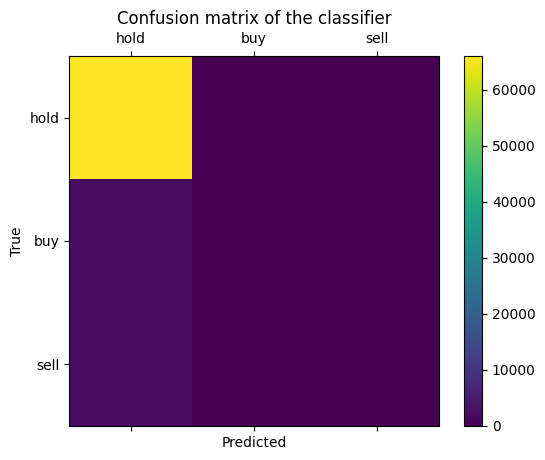

In [26]:
labels = ['hold', 'buy', 'sell']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(lr_cm_train)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

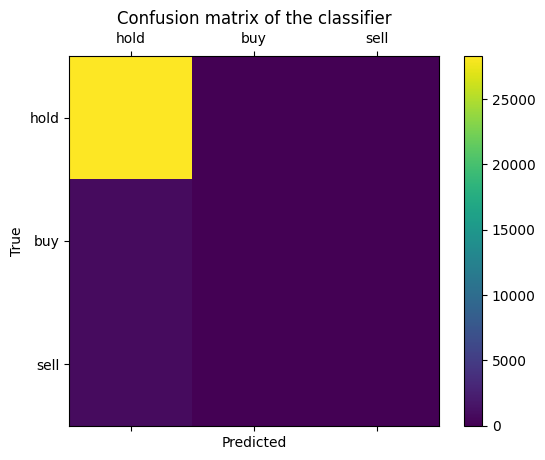

In [27]:
labels = ['hold', 'buy', 'sell']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(lr_cm_test)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
# joblib.dump ( lr_model,f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Logistice Reg {lr_score_test : .2%}.h5")

## Neural Network

In [27]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
import numpy as np

# Assuming you have X_train, y_train, X_test, and y_test as your training and test data

# Determine class weights
class_weights = {
    0: 1.0,  # Weight for class 0
    1: 2.0,  # Weight for class 1
    2: 2.0   # Weight for class 2
}

# Build the neural network model
nn_model = Sequential()
nn_model.add(LSTM(20, input_shape=(4, 1)))
nn_model.add(Dense(120, activation='relu'))
nn_model.add(Dense(3, activation='softmax'))

# Compile the model with weighted loss
nn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


# Train the model with early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)



# Train the model with class weights
nn_model.fit(X_train, y_train, epochs=5, batch_size=32, class_weight=class_weights, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
loss, accuracy = nn_model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/100
1751/1751 [==============================] - 11s 5ms/step - loss: 0.2822 - accuracy: 0.3385 - val_loss: 0.1917 - val_accuracy: 0.5913
Epoch 2/100
1751/1751 [==============================] - 9s 5ms/step - loss: 0.2822 - accuracy: 0.3804 - val_loss: 0.1917 - val_accuracy: 0.5528
Epoch 3/100
1751/1751 [==============================] - 9s 5ms/step - loss: 0.2822 - accuracy: 0.3562 - val_loss: 0.1917 - val_accuracy: 0.6041
Epoch 4/100
1751/1751 [==============================] - 9s 5ms/step - loss: 0.2822 - accuracy: 0.3421 - val_loss: 0.1917 - val_accuracy: 0.1611
Epoch 5/100
1751/1751 [==============================] - 8s 5ms/step - loss: 0.2822 - accuracy: 0.3045 - val_loss: 0.1917 - val_accuracy: 0.4618
Epoch 6/100
938/938 [==============================] - 2s 2ms/step - loss: 0.1956 - accuracy: 0.5937
Loss: 0.19556918740272522
Accuracy: 0.5936739444732666


In [21]:
y_pred = nn_model.predict(X_train)
# print(np.unique(y_pred))

2188/2188 [==============================] - 3s 1ms/step


In [22]:
ypred = []
for row in y_pred:
    ypred.append(
        np.argmax(row)
    )

In [23]:
print(ypred)

[0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 1, 2, 0, 0, 2, 1, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 2, 0, 1, 1, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 

In [45]:
from sklearn.metrics import mean_absolute_percentage_error


mape = mean_absolute_percentage_error(y_train, ypred)
print("MAPE:", mape)


MAPE: 4005915970474630.5


In [46]:

np.unique(ypred),

(array([0, 1, 2], dtype=int64),)

In [47]:
joblib.dump ( nn_model,f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Neural Network {loss : .2%}.h5")

['C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Neural Network  19.42%.h5']

## Naive Bayes

In [48]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train , y_train)

nb_pred_train = nb_model.predict(X_train)
nb_pred_test = nb_model.predict(X_test)

nb_score_train = accuracy_score(y_train, nb_pred_train)
nb_score_test = accuracy_score(y_test, nb_pred_test) 



nb_cm_train = confusion_matrix(y_train, nb_pred_train)
nb_cm_test = confusion_matrix(y_test, nb_pred_test)

nb_clasi_train = classification_report(y_train, nb_pred_train)
nb_clasi_test = classification_report(y_test, nb_pred_test)

In [49]:
print("=="*20)
print(f"accuracy for Train :  { nb_score_train : .2%} ")
print(f"accuracy for Test :   { nb_score_test : .2%} ")
print("--"*20)
print(f"confusion matrix for Train :  \n", nb_cm_train)
print("--"*20)
print(f"confusion matrix for Test : \n" , nb_cm_test)
print("--"*20)
print(f"classification report for Train :\n", nb_clasi_train )
print("--"*20)
print(f"classification report for Test :\n" , nb_clasi_test )


accuracy for Train :   94.33% 
accuracy for Test :    94.31% 
----------------------------------------
confusion matrix for Train :  
 [[66038     0     0]
 [ 2055     0     0]
 [ 1911     0     0]]
----------------------------------------
confusion matrix for Test : 
 [[28296     0     0]
 [  882     0     0]
 [  825     0     0]]
----------------------------------------
classification report for Train :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     66038
           1       0.00      0.00      0.00      2055
           2       0.00      0.00      0.00      1911

    accuracy                           0.94     70004
   macro avg       0.31      0.33      0.32     70004
weighted avg       0.89      0.94      0.92     70004

----------------------------------------
classification report for Test :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     28296
           1       0.00  

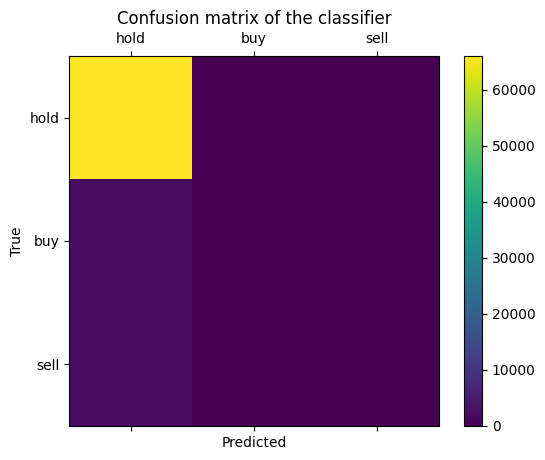

In [50]:
labels = ['hold', 'buy', 'sell']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(nb_cm_train)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

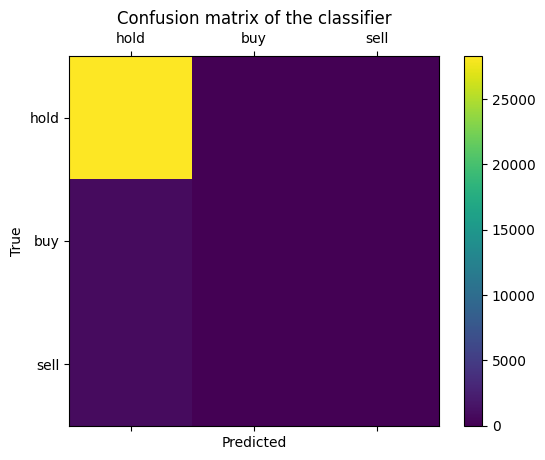

In [51]:
labels = ['hold', 'buy', 'sell']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(nb_cm_test)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
joblib.dump ( nb_model,f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Naive Bayes {nb_score_test : .2%}.h5")

['C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Naive Bayes  94.31%.h5']

## XGBoost

In [53]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train , y_train)
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

xgb_score_train = accuracy_score(y_train, xgb_pred_train)
xgb_score_test = accuracy_score(y_test, xgb_pred_test)  

xcmtrain = confusion_matrix(y_train, xgb_pred_train)
xcmtest = confusion_matrix(y_test, xgb_pred_test)
xgc_train = classification_report(y_train, xgb_pred_train)
xgc_test = classification_report(y_test, xgb_pred_test)

In [54]:
print("=="*20)

print(f"accuracy for Train :  { xgb_score_train : .2%} ")
print(f"accuracy for Test :   { xgb_score_test : .2%} ")
# confusion matrix
print("--"*20)
print(f"confusion matrix for Train :  \n" ,xcmtrain)
print("--"*20)
print(f"confusion matrix for Test : \n" , xcmtest  )
print("--"*20)
print(f"classification report for Train :\n  {xgc_train}")
print("--"*20)
print(f"classification report for Test :\n  {xgc_test}")

accuracy for Train :   95.02% 
accuracy for Test :    94.43% 
----------------------------------------
confusion matrix for Train :  
 [[66035     3     0]
 [ 1817   238     0]
 [ 1669     0   242]]
----------------------------------------
confusion matrix for Test : 
 [[28258    21    17]
 [  845    37     0]
 [  787     0    38]]
----------------------------------------
classification report for Train :
                precision    recall  f1-score   support

           0       0.95      1.00      0.97     66038
           1       0.99      0.12      0.21      2055
           2       1.00      0.13      0.22      1911

    accuracy                           0.95     70004
   macro avg       0.98      0.41      0.47     70004
weighted avg       0.95      0.95      0.93     70004

----------------------------------------
classification report for Test :
                precision    recall  f1-score   support

           0       0.95      1.00      0.97     28296
           1       0.64

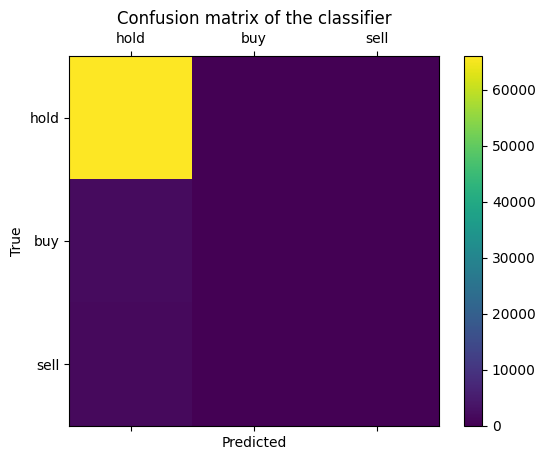

In [55]:
labels = ['hold', 'buy', 'sell']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(xcmtrain)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

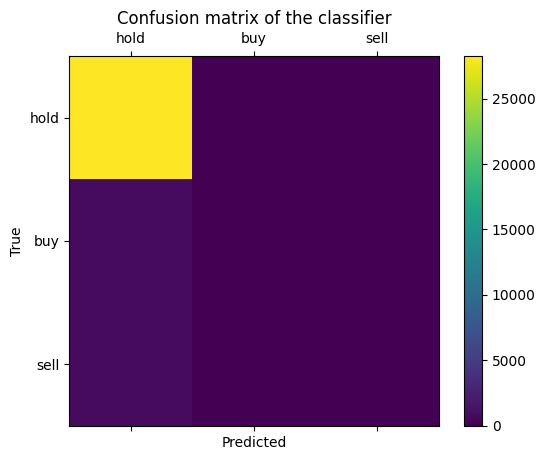

In [56]:
labels = ['hold', 'buy', 'sell']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(xcmtest)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [57]:
joblib.dump ( xgb_model,f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\XGboost {xgb_score_test : .2%}.h5")

['C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\XGboost  94.43%.h5']

## SKlearn MLPclassifier


In [58]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=.0001, activation= "identity",
                    hidden_layer_sizes=(90, 20, 20, 7, 9), random_state=100,  learning_rate="adaptive", verbose= False)


clf.fit(X_train, y_train)


mlp_pred_train = clf.predict(X_train)
mlp_accuracy_train = accuracy_score(y_train, mlp_pred_train)

mlp_pred_test = clf.predict(X_test)
mlp_accuracy_test = accuracy_score(y_test, mlp_pred_test)


In [59]:
print("=="*20)

print(f"accuracy for Train :  {mlp_accuracy_train:.2%} ")
print(f"accuracy for Test :  {mlp_accuracy_test:.2%} ")
# confusion matrix
print("--"*20)
print(f"confusion matrix for Train :  \n" ,xcmtrain_mlp := confusion_matrix(y_train, mlp_pred_train),)
print("--"*20)
print(f"confusion matrix for Test : \n" , xcmtest_mlp := confusion_matrix(y_test, mlp_pred_test))
print("--"*20)
print(f"classification report for Train :\n  {classification_report(y_train, mlp_pred_train)}")
print("--"*20)
print(f"classification report for Test :\n  {classification_report(y_test, mlp_pred_test)}")

accuracy for Train :  94.70% 
accuracy for Test :  94.72% 
----------------------------------------
confusion matrix for Train :  
 [[65569   107   362]
 [ 1800   255     0]
 [ 1439     0   472]]
----------------------------------------
confusion matrix for Test : 
 [[28106    45   145]
 [  775   107     0]
 [  619     0   206]]
----------------------------------------
classification report for Train :
                precision    recall  f1-score   support

           0       0.95      0.99      0.97     66038
           1       0.70      0.12      0.21      2055
           2       0.57      0.25      0.34      1911

    accuracy                           0.95     70004
   macro avg       0.74      0.45      0.51     70004
weighted avg       0.94      0.95      0.93     70004

----------------------------------------
classification report for Test :
                precision    recall  f1-score   support

           0       0.95      0.99      0.97     28296
           1       0.70   

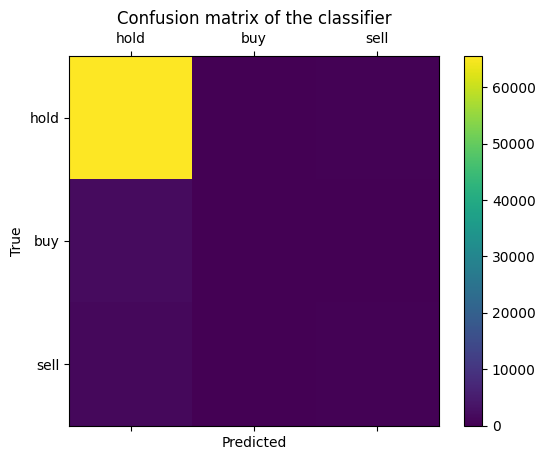

In [60]:
labels = ['hold', 'buy', 'sell']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(xcmtrain_mlp)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

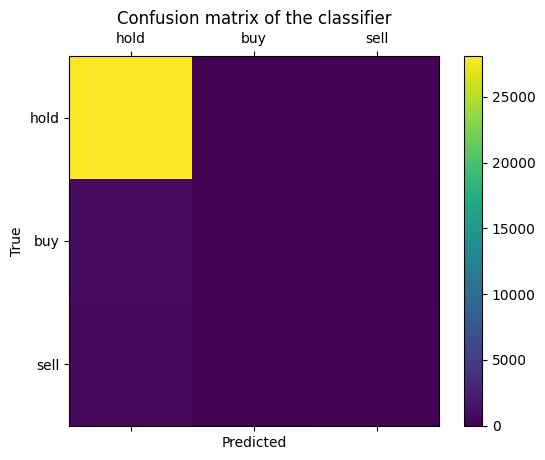

In [61]:
labels = ['hold', 'buy', 'sell']

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(xcmtest_mlp)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
joblib.dump ( clf,f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\MLPClassifier {mlp_accuracy_test : .2%}.h5")

['C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\MLPClassifier  94.72%.h5']

## K Neighbors Classifier


In [63]:
# Create a KNN classifier with 5 neighbors
knn = KNeighborsClassifier(
    n_neighbors=15, weights='distance', metric="euclidean", 
    algorithm='auto', leaf_size=100, n_jobs  = 10)

knn.fit(X_train, y_train)  # Train the model using the training data

knn_y_pred_train = knn.predict(X_train)
knn_y_pred_test = knn.predict(X_test)

# Step 5: Evaluate the model
knn_accuracy_train = accuracy_score(y_train, knn_y_pred_train)
knn_accuracy_test = accuracy_score(y_test, knn_y_pred_test)

knn_classification_report_trian = classification_report(y_train, knn_y_pred_train)
knn_classification_report_test = classification_report(y_test, knn_y_pred_test)



In [64]:
print("=="*20)
print(f"KNN Train Accuracy:  {knn_accuracy_train: .2%}")
print(f"KNN Test Accuracy:  {knn_accuracy_test: .2%}")
print("--"*20)
print(f"classification report for Train :\n {knn_classification_report_trian}")
print(f"classification report for Test :\n {knn_classification_report_test}")


KNN Train Accuracy:   100.00%
KNN Test Accuracy:   94.39%
----------------------------------------
classification report for Train :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     66038
           1       1.00      1.00      1.00      2055
           2       1.00      1.00      1.00      1911

    accuracy                           1.00     70004
   macro avg       1.00      1.00      1.00     70004
weighted avg       1.00      1.00      1.00     70004

classification report for Test :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     28296
           1       0.73      0.02      0.04       882
           2       0.72      0.03      0.05       825

    accuracy                           0.94     30003
   macro avg       0.80      0.35      0.35     30003
weighted avg       0.93      0.94      0.92     30003



[[66038     0     0]
 [    0  2055     0]
 [    0     0  1911]]


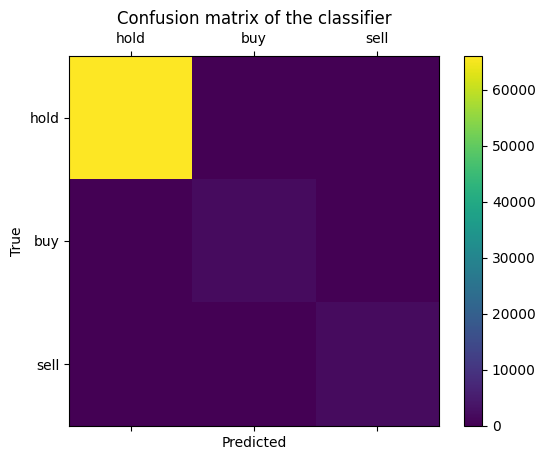

In [65]:
labels = ['hold', 'buy', 'sell']
cm = confusion_matrix(
    y_train, knn_y_pred_train)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[[28281     6     9]
 [  866    16     0]
 [  802     0    23]]


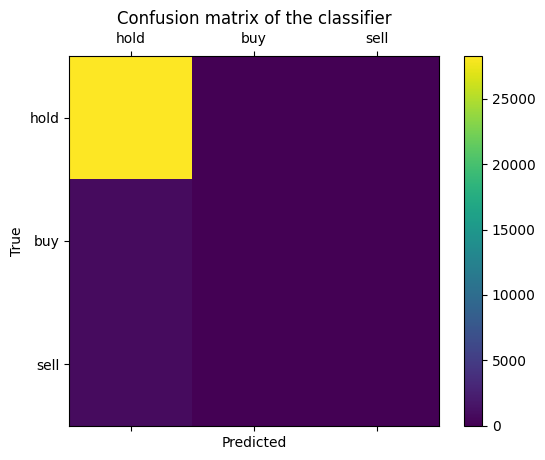

In [66]:
labels = ['hold', 'buy', 'sell']
cm = confusion_matrix(
    y_test, knn_y_pred_test)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [67]:
# Step 6: Save the model in M5 format

joblib.dump(knn, f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\knn_model {knn_accuracy_test :.2%}.h5")

['C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\knn_model 94.39%.h5']

## Decision Tree Classifier


In [68]:
# Create the Decision Tree Classifier
Decision_model = DecisionTreeClassifier(min_samples_split=11,
                                        random_state=10,
                                        criterion="entropy",
                                        )
# Fit the model to your training data
Decision_model.fit(X_train, y_train)
# Predict using the trained model
Decision_y_pred_train= Decision_model.predict(X_train)
Decision_y_pred_test = Decision_model.predict(X_test)

Decision_accuracy_train = accuracy_score(y_train, Decision_y_pred_train)
Decision_accuracy_test = accuracy_score(y_test, Decision_y_pred_test)
Decision_report_train = classification_report(y_train,Decision_y_pred_train )
Decision_report_test = classification_report(y_test,Decision_y_pred_test )



In [69]:
print("==" * 20)
print(f"Decision Train Accuracy: {Decision_accuracy_train: .2%}")
print(f"Decision Test Accuracy: {Decision_accuracy_test: .2%}")
print("--"*20)
print(f"classification report for Train :\n {Decision_report_train}")
print(f"classification report for Train :\n {Decision_report_test}")


Decision Train Accuracy:  97.45%
Decision Test Accuracy:  92.92%
----------------------------------------
classification report for Train :
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     66038
           1       0.83      0.70      0.76      2055
           2       0.83      0.67      0.74      1911

    accuracy                           0.97     70004
   macro avg       0.88      0.79      0.83     70004
weighted avg       0.97      0.97      0.97     70004

classification report for Train :
               precision    recall  f1-score   support

           0       0.96      0.97      0.96     28296
           1       0.33      0.26      0.29       882
           2       0.36      0.26      0.30       825

    accuracy                           0.93     30003
   macro avg       0.55      0.50      0.52     30003
weighted avg       0.92      0.93      0.92     30003



[[65504   285   249]
 [  612  1438     5]
 [  632     1  1278]]


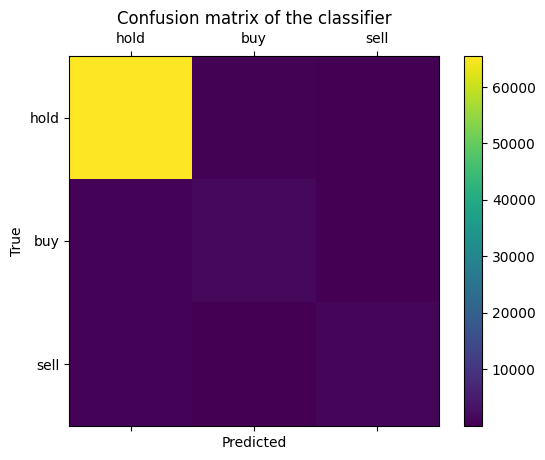

In [70]:
labels = ['hold', 'buy', 'sell']
cm = confusion_matrix(
    y_train, Decision_y_pred_train)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[[27431   478   387]
 [  647   233     2]
 [  608     1   216]]


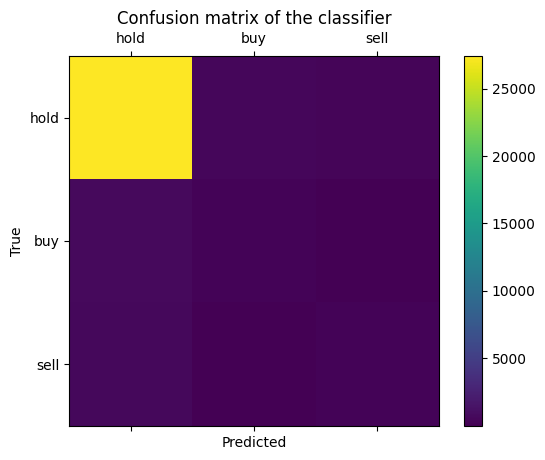

In [71]:
labels = ['hold', 'buy', 'sell']
cm = confusion_matrix(
    y_test, Decision_y_pred_test)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [72]:
joblib.dump(Decision_model, f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Decision Tree model {Decision_accuracy_test: .2%}.h5")


['C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Decision Tree model  92.92%.h5']

## Random Forest Classifier


In [73]:
# Create the Random Forest Classifier
Forest_model = Forest(n_estimators=100,
                      min_samples_split=4,
                      random_state=8
                      )

Forest_model.fit(X_train, y_train)
Forest_y_pred_train = Forest_model.predict(X_train)
Forest_y_pred_test = Forest_model.predict(X_test)


# Calculate accuracy
Forest_accuracy_train = accuracy_score(y_train, Forest_y_pred_train)
Forest_accuracy_test = accuracy_score(y_test, Forest_y_pred_test)

Forest_classification_report_trian = classification_report(y_train, Forest_y_pred_train)
Forest_classification_report_test = classification_report(y_test, Forest_y_pred_test)



In [74]:
print("=="*20)
print(f"Forest Train Accuracy: {Forest_accuracy_train: .2%}")
print(f"Forest Test Accuracy: {Forest_accuracy_test: .2%}")
# Random Forest Classifier
print("--"*20)
print(f"classification report for Train :\n {Forest_classification_report_trian}")
print(f"classification report for Train :\n {Forest_classification_report_test}")


Forest Train Accuracy:  99.65%
Forest Test Accuracy:  94.53%
----------------------------------------
classification report for Train :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     66038
           1       1.00      0.94      0.97      2055
           2       1.00      0.94      0.97      1911

    accuracy                           1.00     70004
   macro avg       1.00      0.96      0.98     70004
weighted avg       1.00      1.00      1.00     70004

classification report for Train :
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     28296
           1       0.63      0.10      0.18       882
           2       0.59      0.11      0.19       825

    accuracy                           0.95     30003
   macro avg       0.72      0.40      0.44     30003
weighted avg       0.93      0.95      0.93     30003



[[66038     0     0]
 [  131  1922     2]
 [  115     0  1796]]


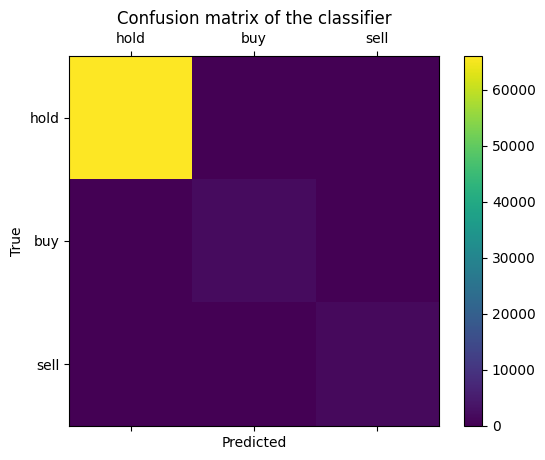

In [75]:
labels = ['hold', 'buy', 'sell']
cm = confusion_matrix(
    y_train, Forest_y_pred_train)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

[[28180    53    63]
 [  791    91     0]
 [  734     0    91]]


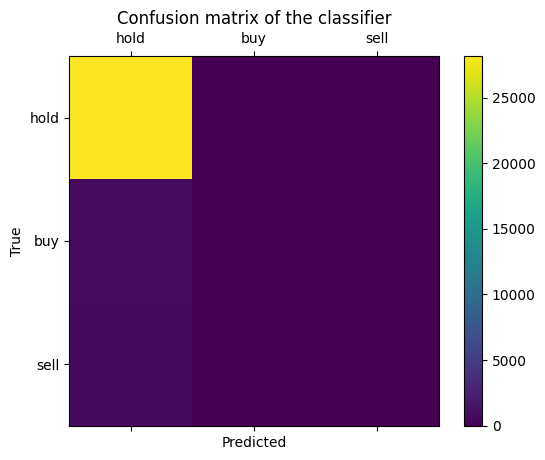

In [76]:
labels = ['hold', 'buy', 'sell']
cm = confusion_matrix(
    y_test, Forest_y_pred_test)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [77]:
joblib.dump(Forest_model,f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Random Forest model {Forest_accuracy_test: .2%}.h5")

['C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\Random Forest model  94.53%.h5']

## Support Vector Machine

In [28]:
svc = SVC(kernel= 'rbf',class_weight='balanced')

svc.fit(X_train, y_train)


In [ ]:
svc_y_pred_train = svc.predict(X_train)
svc_y_pred_test = svc.predict(X_test)

# Step 5: Evaluate the model
svc_accuracy_train = accuracy_score(y_train, svc_y_pred_train)
svc_accuracy_test = accuracy_score(y_test, svc_y_pred_test)

svc_classification_report_trian = classification_report(y_train, svc_y_pred_train)
svc_classification_report_test = classification_report(y_test, svc_y_pred_test)

In [ ]:
print("=="*20)
print(f"SVC Train Accuracy:  {svc_accuracy_train: .2%}")
print(f"SVC Test Accuracy: {svc_accuracy_test: .2%}")
print("--"*20)
print(f"classification report for Train :\n {svc_classification_report_trian}")
print(f"classification report for Test :\n {svc_classification_report_test}")


In [ ]:
labels = ['hold', 'buy', 'sell']
cm = confusion_matrix(
    y_train, svc_y_pred_train)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
labels = ['hold', 'buy', 'sell']
cm = confusion_matrix(
    y_test, svc_y_pred_test)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
joblib.dump(svc, f"C:\\Users\\AmirHussain\\Desktop\\machine-Learning-tradert-bot-main\\Models\\test\\SVC {svc_accuracy_test: .2%}.h5")

# The END